<font size="6.5">**Joint Distribution Fitting for Two Resources**

<font size="3">This file takes raw transaction data as an input. We model the two resources, gas and calldata length, jointly by identifying and separately modeling clusters of the data. The output is a list of generated transactions jointly distributed with resources gas and calldata length. The goal of this file is to find various clusters in the raw dataset and model them with multiple joint distributions. Then, we can simulate transactions based on the estimated parameters of the cluster distributions.

    
<font size="3">The input file TxF22.csv is generated with scraper.py

In [104]:
#Import necessary packages, raw data file, clean call data, and creates shuffled data frame

import sys; sys.path.insert(0, '..')  # this adds the parent directory into the path, since we want simulations from the parent directory
from settings import DATA_PATH

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
from sklearn.utils import shuffle
import random
from sklearn.linear_model import LinearRegression
import seaborn as sns
from collections import Counter 
from math import e
from random import randint
from collections import Counter

file='transactionData.csv'
data=pd.read_csv(str(DATA_PATH / file)) 

TxGas=list(data['executionGas']) #gas used per Tx
TxCallData=list(data['callDataUsage'])
# TxCallData=[len(x[2:]) for x in TxCallData] #length of calldata after '0x' string for each entry

np.random.seed(10)
(TxGas,TxCallData) = shuffle(TxGas,TxCallData) 

testSize=20 # % of Txs that will make up test set
TxGasTest=TxGas[0:round(len(TxGas)*testSize/100)]
TxGasTrain=TxGas[round(len(TxGas)*testSize/100):]

TxCallDataTest=TxCallData[0:round(len(TxCallData)*testSize/100)]
TxCallDataTrain=TxCallData[round(len(TxCallData)*testSize/100):]

dfTrain=pd.DataFrame({'TxGas':TxGasTrain,'TxCallData':TxCallDataTrain})
dfTest=pd.DataFrame({'TxGas':TxGasTest,'TxCallData':TxCallDataTest})


<font size="5">**Data Preparation**

<font size="3">Here we import necessary packages before pulling in and cleaning the data. We also split the data into test and training sets so that we can build the model on a training set and compare its performance to the test set in order to avoid overfitting.


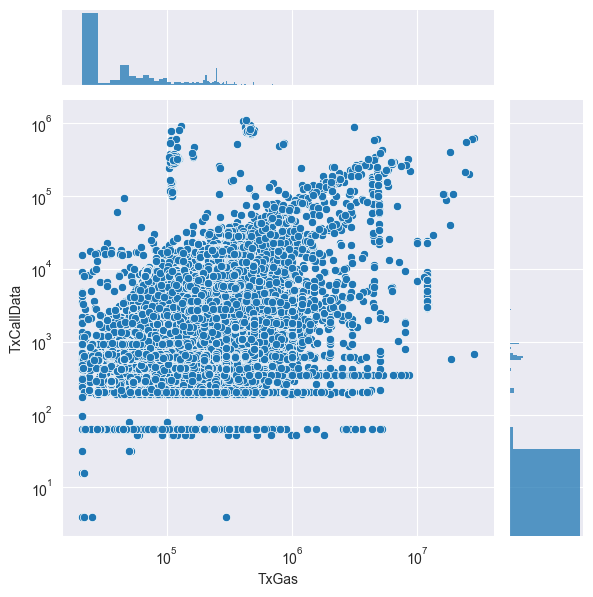

In [105]:
jp=sns.jointplot(data=dfTrain, x="TxGas", y="TxCallData");
jp.ax_joint.set_xscale('log')
jp.ax_joint.set_yscale('log')

<font size="5">**Histograms and Scatter of Calldata Length vs Gas on a Log-Log Scale**
    
<font size="3">Visualizing the data on a log-log scale clearly shows various clusters of data. Note the obvious correlation between resources, which indicates that marginal distribution fitting can be improved upon. Data appears as either horizontal or vertical lines, or as a large blob. To understand the data better, we can characterize these clusters (in later cells) and fit separate distributions to the data at fixed gas and/or calldata length values.


<font size="5">**Set Conditions for Determining Clusters**
    
<font size="3">If the proportion of gas values at a given gas value is larger than the ``ratioLimitGas`` variable (or ``ratioLimitCallData` in separately considered CD values), we will create special conditions to generate points from a different joint distribution. 
  
<font size="3">This is first used to see if any gas value occurs at least this often in the set. Then if any corresponding calldata length value occurs at that gas value over ``ratioLimitGas``, we will later generate transactions at this exact gas and calldata value at the proportion we see it in the set. If the there are other calldata values corresponding to the current gas value being evaluated, we check if they all make up a total of over ``ratioLimitGas`` and generate from a distribution later (using gamma parameters estimated from calldata lengths at this gas value). We then repeat this process for calldata using ``ratioLimitCallData``
    
<font size="3">We also set ``lenGenerated`` to define how many transactions we wish to simulate.


In [106]:
#Find most common Gas
ratioLimitGas=0.02 #If the count of gas values divided by the total values is over this ratio, we will create special conditions to generate points from another joint distribution. This is first used to see if any gas val occurs at least this often in the set. Then if any corresponding cd len value occurs at that gas value over ratio, we will later generate this exact gas and cd value at the proportion we see it in the set. If the there are other cd values corresponding to the current gas value being evaluated, we check if they all make up a total of over this ratio and generate from a distribution later (using parameters derived from cd lengths at this gas value). Note a limitation of this methodology is that it's possible for a gas value to have a specific cd length over this ratio and the rest of the cd values not summing to over this ratio. Therefore, the current code will not incorporate these points when generating the joint distribution.
ratioLimitCallData=ratioLimitGas
minNumGasValsForDistr=2      #if set to 2 for example, only generates from a distribution if that gas value occurs 3+ times (not including any gas,cd combinations that were at a proportion > the ratio limits)
minNumCallDataValsForDistr=1 #if set to 2 for example, only generates from a distribution if that CD  value occurs 3+ times (not including any gas,cd combinations that were at a proportion > the ratio limits)
lenGenerated=5000 #number of Txs to be jointly simulated. Instead of looping thru this length, we multiply each cluster proportion by this to end up with realistic ratios of clusters being generated.


<font size="5">**Finding 'Point' Clusters and Fixed Gas Value Clusters**
    
<font size="3">We loop through all gas values in the dataset and evaluate if any (calldata,gas value) points make up more than ``ratioLimitGas`` of the set (i.e. >2% of the data). If there are any, we store these and later we create the ``specialGeneration`` df with these entered as type 'Point'. 
 
<font size="3">We can then look at all other calldata length values at each gas value and see if their proportions sum to more than the ``ratioLimitGas``. If so, these are stored and later we create the ``specialGeneration`` df with these entered as type 'GasDistribution'. These are also stored in ``commonGas`` to be used in the chart as red vertical lines.

<font size="3">We then repeat this process for calldata by looping through gas values at each calldata length to see if their proportions sum to more than the ``ratioLimitCallData``. These are also stored in ``commonCallData`` to be used in the chart as green horizontal lines.    

In [107]:
commonGas=[]
topGasPoints=[]
topGasDistr=[]

for gasVal,gasValCount in (dict(Counter(dfTrain.TxGas)).items()): 
    if gasValCount/len(dfTrain) > ratioLimitGas: #if gas value is present in high proportion of dataset
        s=0
        commonGas.append(gasVal) #used later to make vertical lines in plot
        for CallDataLen,CallDataLenCount in dict(Counter(list(dfTrain[dfTrain.TxGas==gasVal].TxCallData))).items():
            if CallDataLenCount/len(dfTrain) > ratioLimitGas: 
                topGasPoints.append((gasVal,list(Counter(list(dfTrain[dfTrain['TxGas']==gasVal].TxCallData)).keys())[s],round(CallDataLenCount/len(dfTrain),3),len(list(Counter(list(dfTrain[dfTrain['TxGas']==gasVal].TxCallData)).keys())[:])))
            else:
                topGasDistr.append((gasVal,list(Counter(list(dfTrain[dfTrain['TxGas']==gasVal].TxCallData)).keys())[s],round(CallDataLenCount/len(dfTrain),3),len(list(Counter(list(dfTrain[dfTrain['TxGas']==gasVal].TxCallData)).keys())[:])))
            s=s+1

commonDf=pd.DataFrame(topGasPoints,columns=['Gas Value','Calldata Length','Ratio of Dataset','# times in set'])

commonDFRemainingGas=pd.DataFrame(topGasDistr,columns=['Gas Value','Calldata Length','Ratio of Dataset','# times in set'])
vc = commonDFRemainingGas['Gas Value'].value_counts()         
commonDFRemainingGas=commonDFRemainingGas[commonDFRemainingGas['Gas Value'].isin(vc.index[vc.gt(minNumGasValsForDistr)])]

countGasLens=commonDFRemainingGas.groupby('Gas Value').count()['# times in set']
commonDFRemainingGas=commonDFRemainingGas.drop(columns=['# times in set']) #drop column
commonDFRemainingGas=commonDFRemainingGas.groupby(by=["Gas Value"]).sum() 
commonDFRemainingGas['# Corresponding CD Values in Set After Point Generation']=countGasLens
commonDFRemainingGas=commonDFRemainingGas.drop(columns=['Calldata Length']) #drop irrelevant column
commonDFRemainingGas=commonDFRemainingGas[commonDFRemainingGas['Ratio of Dataset'] >=ratioLimitGas] #look at the ratio of the dataset that each gas value encompasses across all CD values



commonCallData=[]
topCallDataDistr=[]
for callDataVal,callDataValCount in (dict(Counter(dfTrain.TxCallData)).items()): 
    if callDataValCount/len(dfTrain) > ratioLimitCallData: #if cd is present in high proportion of dataset
        s=0
        commonCallData.append(callDataVal) #used later to make vertical lines in plot
        for gasLen,gasLenCount in dict(Counter(list(dfTrain[dfTrain.TxCallData==callDataVal].TxGas))).items():
            if gasLenCount/len(dfTrain) > ratioLimitCallData: 
                continue #no need to repeat for calldata points bc will be the same as topGasPoints. specialGeneration Type: 'Points' already covered 
            else:
                topCallDataDistr.append((list(Counter(list(dfTrain[dfTrain['TxCallData']==callDataVal].TxGas)).keys())[s],callDataVal,round(gasLenCount/len(dfTrain),10),     len(list(Counter(list(dfTrain[dfTrain['TxCallData']==callDataVal].TxGas)).keys())[:])))
            s=s+1

commonDFRemainingCallData=pd.DataFrame(topCallDataDistr,columns=['Gas Value','Calldata Length','Ratio of Dataset','# times in set'])
vc = commonDFRemainingCallData['Calldata Length'].value_counts()         
commonDFRemainingCallData=commonDFRemainingCallData[commonDFRemainingCallData['Calldata Length'].isin(vc.index[vc.gt(minNumCallDataValsForDistr)])] #This determines how many points needed to estimate distribution parameters. if not enough, no generation occurs.

countCDLens=commonDFRemainingCallData.groupby('Calldata Length').count()['# times in set']
commonDFRemainingCallData=commonDFRemainingCallData.drop(columns=['# times in set']) #drop column
commonDFRemainingCallData=commonDFRemainingCallData.groupby(by=["Calldata Length"]).sum() 
commonDFRemainingCallData['# Corresponding Gas Values in Set After Point Generation']=countCDLens 
commonDFRemainingCallData=commonDFRemainingCallData.drop(columns=['Gas Value']) #drop irrelevant column
commonDFRemainingCallData=commonDFRemainingCallData[commonDFRemainingCallData['Ratio of Dataset'] >=ratioLimitCallData] #look at the ratio of the dataset that each cd value encompasses across all gas values


<font size="5">**Merging Data Frames to Define Clusters**
    
<font size="3">We merge the data frames to create ``specialGeneration``. At this point, point clusters, fixed calldata clusters, and fixed gas clusters are identified. This data frame is later filled with distribution parameters that we can use to generate transactions.
    

In [108]:
#Now merge DFs together that identify gas,cd points for special Tx generation as well as individual gas and cd values that will have distributions fit and generated randomly from them
commonDf['Type'] = 'Point'#this is all the gas,cd common points that will be generated at the proportion they appear in the dataset
commonDFRemainingGas['Type'] = 'GasDistribution'
commonDFRemainingCallData['Type'] = 'CDDistribution'

tempDf=commonDf.merge(commonDFRemainingGas, how='outer', on=['Gas Value','Ratio of Dataset','Type'])
specialGeneration=tempDf.merge(commonDFRemainingCallData, how='outer', on=['Calldata Length','Ratio of Dataset','Type']).drop(columns=['# times in set','# Corresponding CD Values in Set After Point Generation','# Corresponding Gas Values in Set After Point Generation'])


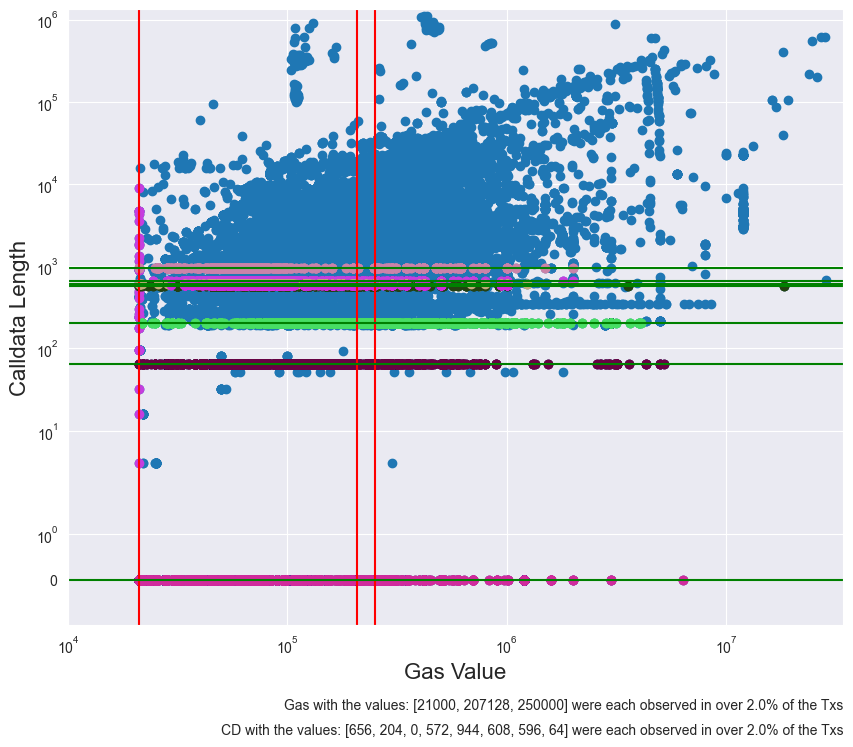

In [109]:
#Create plots of CD vs Gas
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(dfTrain['TxGas'],dfTrain['TxCallData'])
ax.set_xscale('symlog')
ax.set_yscale('symlog')

colors = []
for i in range(len(commonCallData)):
    random.seed(i*22)
    colors.append('#%06X' % randint(0, 0xFFFFFF))
    
ss=0
for i in commonCallData:
    ax.scatter(dfTrain[dfTrain['TxCallData']==i].TxGas,dfTrain[dfTrain['TxCallData']==i].TxCallData,color=colors[ss])
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')
    ss=ss+1

colors2 = []   
for i in range(len(commonGas)):
    random.seed(i*8)
    colors2.append('#%06X' % randint(0, 0xFFFFFF))

sss=0
for i in commonGas:
    ax.scatter(dfTrain[dfTrain['TxGas']==i].TxGas,dfTrain[dfTrain['TxGas']==i].TxCallData,color=colors2[sss])
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')
    sss=sss+1
    

ss=0
for i in commonCallData:
    ax.scatter(dfTrain[dfTrain['TxCallData']==i].TxGas,dfTrain[dfTrain['TxCallData']==i].TxCallData,color=colors[ss])
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')
    ss=ss+1

    
    
for i in range(len(commonGas)):
    plt.axvline(x=commonGas[i],color='r')    
for i in range(len(commonCallData)):
    plt.axhline(y=commonCallData[i],color='g')    

ax.annotate('Gas with the values: '+str(commonGas)+' were each observed in over '+str(100*ratioLimitGas)+'% of the Txs',xy = (1, -0.13),xycoords='axes fraction',ha='right',va="center",fontsize=10)
ax.annotate('CD with the values: '+str(commonCallData)+' were each observed in over '+str(100*ratioLimitCallData)+'% of the Txs',xy = (1, -0.17),xycoords='axes fraction',ha='right',va="center",fontsize=10)
plt.xlabel('Gas Value', fontsize=16)
plt.ylabel('Calldata Length', fontsize=16)
plt.xlim([1e4, np.max(dfTrain.TxGas)*1.2])
plt.ylim([-1, np.max(dfTrain.TxCallData)*1.2])

plt.show()





<font size="5">**Cluster Identification Chart**
    
<font size="3">Green horizontal lines represent calldata lengths that appear at more than ``ratioLimitCallData``, while red vertical lines represent gas values that appear at more than ``ratioLimitGas``.
    

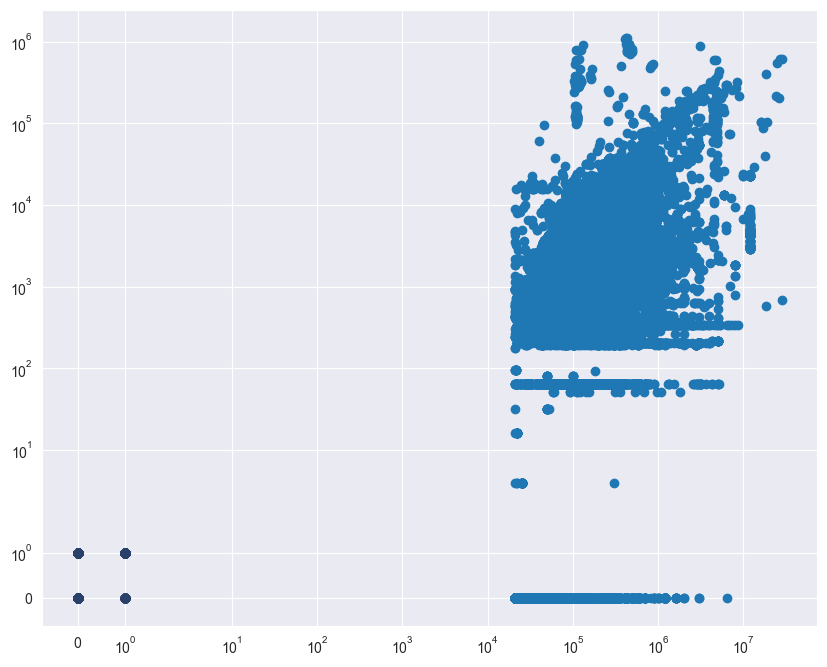

In [110]:
#THIS IS AN INCOMPLETED ATTEMPT TO REFACTOR THE CHART WITH LINES. if completed, replace the cell above with this
def make_colors(seed_mult,numColors):
    colors = []
    for i in range(numColors):
        random.seed(seed_mult*i)
        colors.append('#%06X' % randint(0, 0xFFFFFF))
    return colors

colorsCD = make_colors(22,(np.sum(specialGeneration.Type=='CDDistribution')))
colorsGas = make_colors(8,np.sum(specialGeneration.Type=='GasDistribution'))
colorsPoint = make_colors(3,np.sum(specialGeneration.Type=='Point'))




fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(dfTrain['TxGas'],dfTrain['TxCallData']) #plot all points and then print over them with different colors by distr type below

for i in range(len(specialGeneration)):
    if specialGeneration.Type[i]=='Point':
        for j in range(len(colorsPoint)):
            ax.set_xscale('symlog')
            ax.set_yscale('symlog')
            ax.scatter(dfTrain['TxGas']==specialGeneration.loc[i]['Gas Value'],dfTrain['TxCallData']==specialGeneration.loc[i]['Calldata Length'],color=colorsPoint[j])
        
    if specialGeneration.Type[i]=='CDDistribution':
        ax.set_xscale('symlog')
        ax.set_yscale('symlog')
        
    if specialGeneration.Type[i]=='GasDistribution':
        ax.set_xscale('symlog')
        ax.set_yscale('symlog')
        


<font size="5">**Parameter Estimation**
    
<font size="3">For commonly seen gas values, the gas value is fixed and calldata lengths are used to estimate gamma parameters. For commonly seen calldata lengths, the calldata length is fixed and gas values are used to estimate gamma parameters.
    

In [111]:
#Now find gamma parameters for clusters:

specialGeneration['Alpha Gamma Parameter']='NaN'
specialGeneration['Beta Gamma Parameter']='NaN'
locGas=21000 #location parameter of gas

for i in range(len(specialGeneration)): 
    if specialGeneration['Type'].loc[i]=='GasDistribution':
        specialGeneration['Alpha Gamma Parameter'].loc[i]=(np.mean(  dfTrain[dfTrain.TxGas==specialGeneration['Gas Value'][i]].TxCallData   ))**2/np.var( dfTrain[dfTrain.TxGas==specialGeneration['Gas Value'][i]].TxCallData   )
        specialGeneration['Beta Gamma Parameter'].loc[i]= (np.mean(  dfTrain[dfTrain.TxGas==specialGeneration['Gas Value'][i]].TxCallData   ))/np.var( dfTrain[dfTrain.TxGas==specialGeneration['Gas Value'][i]].TxCallData   )
    if specialGeneration['Type'].loc[i]=='CDDistribution':
        specialGeneration['Alpha Gamma Parameter'].loc[i]=(np.mean(  dfTrain[dfTrain.TxCallData==specialGeneration['Calldata Length'][i]].TxGas   ))**2/np.var( dfTrain[dfTrain.TxCallData==specialGeneration['Calldata Length'][i]].TxGas   )
        specialGeneration['Beta Gamma Parameter'].loc[i]= (np.mean(  dfTrain[dfTrain.TxCallData==specialGeneration['Calldata Length'][i]].TxGas   ))/np.var( dfTrain[dfTrain.TxCallData==specialGeneration['Calldata Length'][i]].TxGas   )
        
        

/var/folders/0r/39rsm7c137z2fwzdl5f0ynbc0000gn/T/ipykernel_10568/82764486.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specialGeneration['Alpha Gamma Parameter'].loc[i]=(np.mean(  dfTrain[dfTrain.TxCallData==specialGeneration['Calldata Length'][i]].TxGas   ))**2/np.var( dfTrain[dfTrain.TxCallData==specialGeneration['Calldata Length'][i]].TxGas   )
/var/folders/0r/39rsm7c137z2fwzdl5f0ynbc0000gn/T/ipykernel_10568/82764486.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specialGeneration['Beta Gamma Parameter'].loc[i]= (np.mean(  dfTrain[dfTrain.TxCallData==specialGeneration['Calldata Length'][i]].TxGas   ))/

<font size="5">**Transaction Generation**
    
<font size="3">We loop through all entries in the ``specialGeneration`` data frame and generate transactions at the proportion that that cluster appears in the raw dataset. We simultaneously create the ``dfRemaining`` data frame to make a set of the remaining data that must be generated. This defines the final cluster which is represented by the blue points in the chart above.
    

In [112]:
TxGenerated=[] # list of (gas,CD) tuples
dfRemaining=dfTrain #initialize with full df and then reduce rows

for i in range(len(specialGeneration)): 
    if specialGeneration['Type'].loc[i]=='GasDistribution':
        dfRemaining=dfRemaining.drop(dfRemaining[dfRemaining.TxGas == specialGeneration['Gas Value'][i]].index)
        TxGenerated=TxGenerated+(  list(zip( [specialGeneration['Gas Value'][i]]*round(lenGenerated*specialGeneration['Ratio of Dataset'].loc[i])    ,            list(stats.gamma.rvs(specialGeneration['Alpha Gamma Parameter'].loc[i], scale=1/specialGeneration['Beta Gamma Parameter'].loc[i],size=round(lenGenerated*specialGeneration['Ratio of Dataset'].loc[i]) ))))     )
    if specialGeneration['Type'].loc[i]=='CDDistribution':
        dfRemaining=dfRemaining.drop(dfRemaining[dfRemaining.TxCallData == specialGeneration['Calldata Length'][i]].index)
        TxGenerated=TxGenerated+(  list(zip(    list(stats.gamma.rvs(specialGeneration['Alpha Gamma Parameter'].loc[i], scale=1/specialGeneration['Beta Gamma Parameter'].loc[i],loc=locGas,size=round(lenGenerated*specialGeneration['Ratio of Dataset'].loc[i]) )), [specialGeneration['Calldata Length'][i]]*round(lenGenerated*specialGeneration['Ratio of Dataset'].loc[i]) ))     )
    if specialGeneration['Type'].loc[i]=='Point':
        dfRemaining=dfRemaining.drop(dfRemaining[(dfRemaining.TxCallData == specialGeneration['Calldata Length'][i]) & (dfRemaining.TxGas == specialGeneration['Gas Value'][i])].index)
        TxGenerated=TxGenerated+(  list(zip(    [specialGeneration['Gas Value'][i]]*round(lenGenerated*specialGeneration['Ratio of Dataset'].loc[i])   ,                         [specialGeneration['Calldata Length'][i]]*round(lenGenerated*specialGeneration['Ratio of Dataset'].loc[i]) )))
remainingLength=lenGenerated-round(np.sum(lenGenerated*specialGeneration['Ratio of Dataset']) )



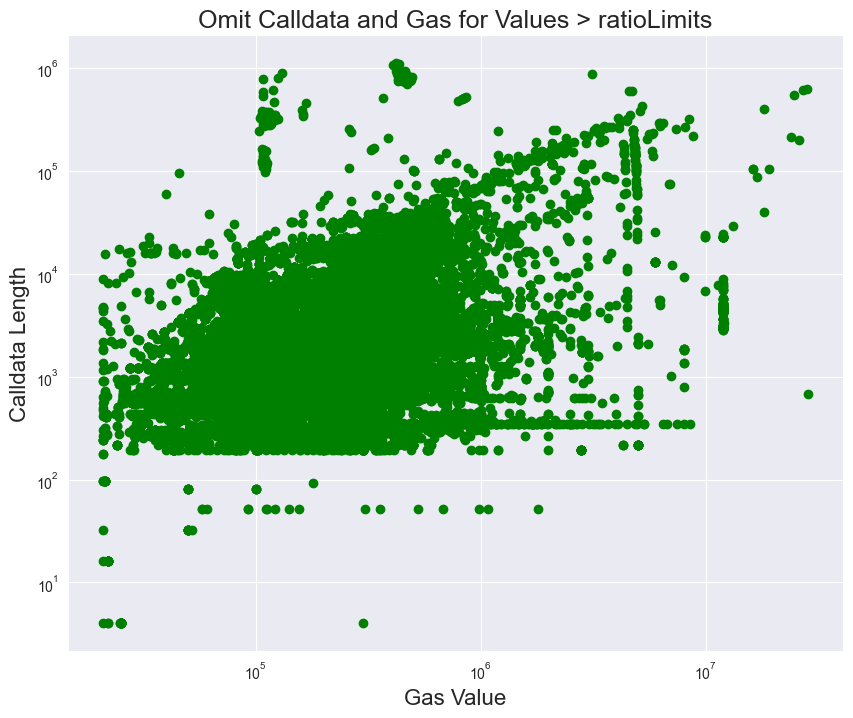

In [113]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(dfRemaining['TxGas'],dfRemaining['TxCallData'],c='g')
ax.set_xscale('symlog')
ax.set_yscale('symlog')
plt.title('Omit Calldata and Gas for Values > ratioLimits', fontsize=18)
plt.xlabel('Gas Value', fontsize=16)
plt.ylabel('Calldata Length', fontsize=16)
plt.show()


<font size="5">**Visualization of Remaining Data**
    
<font size="3">All previously unmodeled data in the ``dfRemaining`` data frame is plotted here. These are data that were not identified clusters in the horizontal and vertical lines in the chart above, but must stil be modeled. On a log-log scale, data appears somewhat Gaussian, so we model the data as multivariate lognormal.


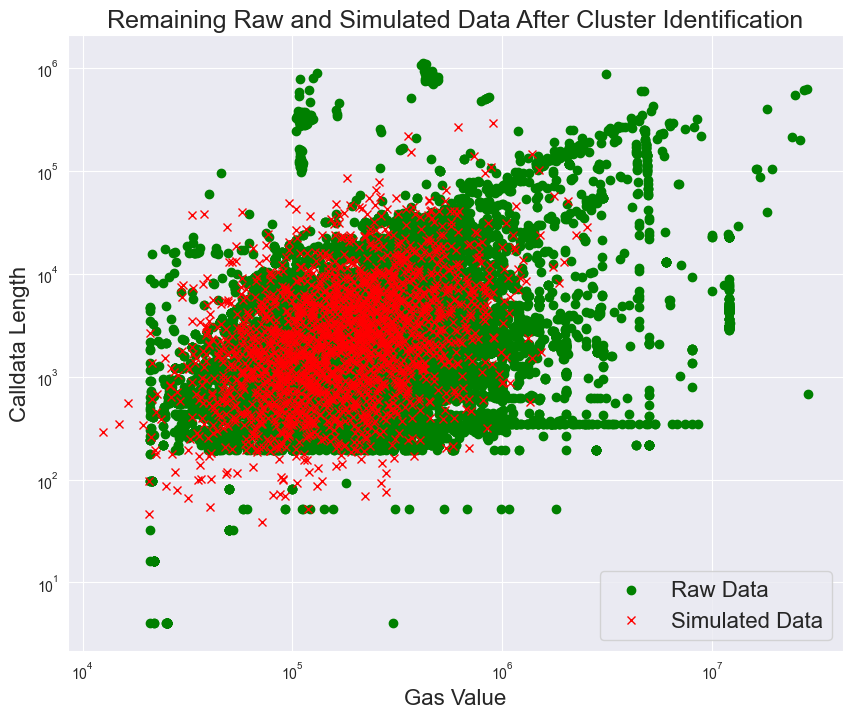

/var/folders/0r/39rsm7c137z2fwzdl5f0ynbc0000gn/T/ipykernel_10568/16203134.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  specialGeneration = specialGeneration.append({'Mu Lognormal Parameter': [logMuGas,logMuCallData], 'Cov Lognormal Parameter': logCovMat, 'Type': 'Remaining'}, ignore_index = True)


In [114]:
#Model the rest of the data
logGas=np.log(dfRemaining['TxGas'])
logCallData=np.log(dfRemaining['TxCallData'])
logCovMat=np.cov(logGas,logCallData)
logMuGas=np.mean(logGas)
logMuCallData=np.mean(logCallData)

fig,ax=plt.subplots(figsize=(10,8))
x, y = np.random.multivariate_normal([logMuGas,logMuCallData], logCovMat, remainingLength).T
ax.scatter(dfRemaining['TxGas'],dfRemaining['TxCallData'],color='g',label='Raw Data')
plt.plot(np.exp(x), np.exp(y), 'x',color='r',label='Simulated Data')
plt.title('Remaining Raw and Simulated Data After Cluster Identification', fontsize=18)
plt.xlabel('Gas Value', fontsize=16)
ax.set_xscale('symlog')
ax.set_yscale('symlog')
plt.ylabel('Calldata Length', fontsize=16)
plt.legend(fontsize=16)
plt.show()

TxGenerated=TxGenerated+( list(zip(np.exp(x),np.exp(y)) ))   


# Add lognormal parameters to the specialGeneration Table


specialGeneration['Mu Lognormal Parameter']='NaN'
specialGeneration['Cov Lognormal Parameter']='NaN'


specialGeneration = specialGeneration.append({'Mu Lognormal Parameter': [logMuGas,logMuCallData], 'Cov Lognormal Parameter': logCovMat, 'Type': 'Remaining'}, ignore_index = True)



In [115]:
additive_ratio = [np.sum(specialGeneration["Ratio of Dataset"][0:x+1]) for x in range(len(specialGeneration["Ratio of Dataset"]))]
additive_ratio[-1] = 1
specialGeneration["Additive Ratio"] = additive_ratio
display(specialGeneration)
specialGeneration.to_csv(str(DATA_PATH)+"/specialGeneration.csv")

,Gas Value,Calldata Length,Ratio of Dataset,Type,Alpha Gamma Parameter,Beta Gamma Parameter,Mu Lognormal Parameter,Cov Lognormal Parameter,Additive Ratio
0,21000.0,0.0,0.266000,Point,NaN,NaN,NaN,NaN,0.266000
1,207128.0,0.0,0.022000,Point,NaN,NaN,NaN,NaN,0.288000
2,250000.0,0.0,0.023000,Point,NaN,NaN,NaN,NaN,0.311000
3,NaN,0.0,0.064162,CDDistribution,0.420516,0.000007,NaN,NaN,0.375162
4,NaN,64.0,0.023984,CDDistribution,0.648398,0.000003,NaN,NaN,0.399146
5,NaN,204.0,0.026387,CDDistribution,0.313916,0.000001,NaN,NaN,0.425532
6,NaN,572.0,0.036557,CDDistribution,0.061386,0.000001,NaN,NaN,0.462090
7,NaN,596.0,0.022004,CDDistribution,2.0928,0.000013,NaN,NaN,0.484094
8,NaN,608.0,0.046728,CDDistribution,1.930707,0.000012,NaN,NaN,0.530822
9,NaN,656.0,0.025598,CDDistribution,1.099306,0.000007,NaN,NaN,0.556420


<font size="5">**Generating Remaining Data**
    
<font size="3">We model this final cluster with a multivariate log-normal distribution. We use the remaining set to estimate parameters and then generate transactions following this distribution at the propotion they appear in the raw data. To ensure this cluster is well represented by our model, we plot it alongside generated transactions.

<font size="5">**Comparing Raw and Simulated Data**
    
<font size="3">To evaluate the effectiveness of the simulation, we can compare the simulated data to the raw data. **Note: FIND SOME METRICS TO COMPARE 2D DISTRIBUTIONS... NO 2D KOLMOGOROV IN PYTHON PACKAGES**
    
> See my comments in discord.

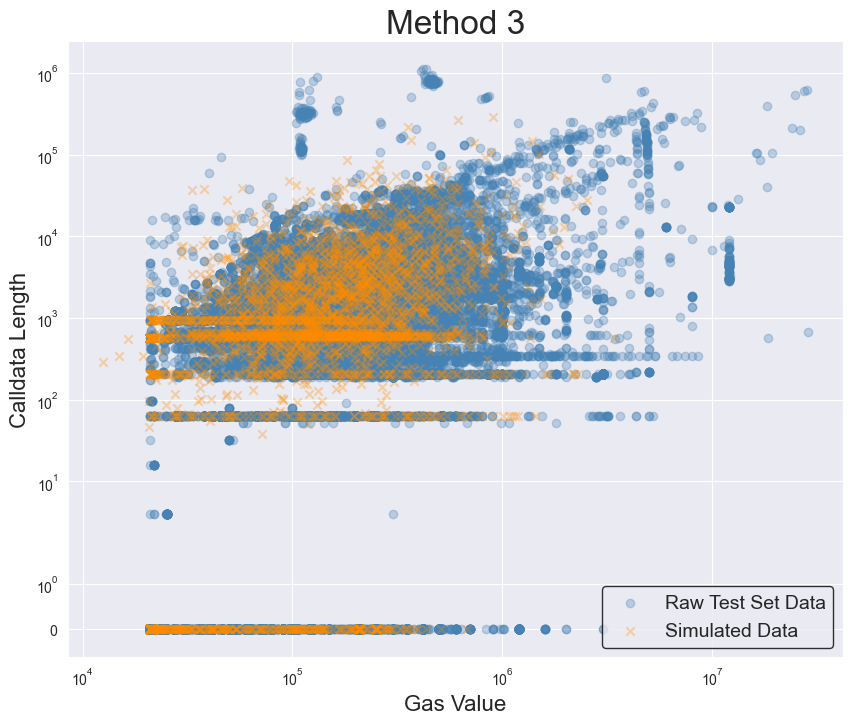

In [116]:
TxGeneratedGas=[TxGenerated[i][0] for i in range(len(TxGenerated))]
TxGeneratedCallData=[TxGenerated[i][1] for i in range(len(TxGenerated))]

fig,ax=plt.subplots(figsize=(10,8))
ax.scatter(dfTrain['TxGas'],dfTrain['TxCallData'],alpha=.3,label='Raw Test Set Data',color='steelblue')
ax.scatter(TxGeneratedGas,TxGeneratedCallData,alpha=.3,label='Simulated Data',marker='x',color='darkorange')
plt.title('Method 3', fontsize=24)
plt.xlabel('Gas Value', fontsize=16)
plt.ylabel('Calldata Length', fontsize=16)
ax.set_xscale('symlog')
ax.set_yscale('symlog')
plt.legend(fontsize=14,edgecolor='k')
plt.show()


now we look at various call data strings

In [117]:

Counter(data['input']).most_common

KeyError: 'input'

In [ ]:
proportionCDLensAnalyzed=.02 #if the cd length appears over this ratio, we look at it
#list(data['input'])
mostCommonCDVals=list((np.sort([float(list(Counter(TxCallData).keys())[i])  for i in range(len(list(Counter(TxCallData).keys())))  if (float(list(Counter(TxCallData).values())[i])/len(TxCallData)>proportionAnalyzed)])).astype(int))

dictCD=dict()
a=[]
for i in range(len(mostCommonCDVals)):
    #for j in range(len(list(data['input']))):
        #if mostCommonCDVals[i]==
    
    a.append([list(data['input'])[j] for j in range(len(list(data['input']))) if (len(list(data['input'])[j])-2)==mostCommonCDVals[i]])
        #dictCD={'key':mostCommonCDVals[i] , 'value':(list(data['input'])[j])}



In [ ]:
proportionCDLensAnalyzed=.1 #if the cd string appears over this ratio compared to it's cd length, we look at it
aa=[Counter(i) for i in a]
aa


In [ ]:
df=pd.DataFrame()
for i in range(len(aa)): #loop thru all k,v pairs. each list entry is a dict of
    for j in range(len((dict(aa[i]).values()))):
        if (list(dict(aa[i]).values())[j])/ > proportionCDLensAnalyzed: #consider the cd string if it appears at a proportion at least as big as this, compared to all cd strings of this length
            print()
        #df[len(dict(aa[i]).keys())]
    
    
    
    
    
    